# Graphene with a single Hydrogen adatom

## Import statements

In [3]:
import kwant
import tinyarray
import numpy as np
import matplotlib.pyplot as plt

## Definition of the system

Let's start by defining a system without SOC terms, but with two orbitals per site representing the spin. To do so, we've adopted the `general` lattice definition from `kwant.lattice` module. Such a function needs the primitive vectors and the coordinates of the basis atoms:

**Primitive vectors:**
* (1, 0)
* ($\sin 30°$, $\cos 30°$)

**Coordinates of basis atoms:**
* (0, 0)
* (0, $\frac{1}{\sqrt 3}$)

In [2]:
## Define the graphene lattice
sin_30, cos_30 = (1/2, np.sqrt(3)/2)
graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)], # primitive vectors
                                 [(0, 0), (0, 1 / np.sqrt(3))], # coord. of basis atoms
                                 name='Graphene'             # tag of identification
                                )
## Split in sublattices
a, b = graphene.sublattices

### Builder function:

In [3]:
class Rectangle:
    """
    Class to define callable objects to define the 
    shape of the scattering region of a rectangular
    system.
    """
    def __init__(self, W, L):
        '''
        Calling the scattering region as strip:
        W = width of the strip
        L = length of the strip 
        '''
        self.W = W
        self.L = L
        
    def __call__(self, pos):
        W, L = self.W, self.L
        x, y = pos
        return -W/2 < y < W/2 and -L/2 <= x <= L/2
    
    def leads(self, pos):
        W = self.W
        _, y = pos
        return -W/2 < y < W/2

def make_graphene_strip(lattice, scatter_shape, hopping=1, on_site=0):    
    syst = kwant.Builder()
    syst[lattice.shape(scatter_shape, (0, 0))] = on_site

    # specify the hoppings of the graphene lattice in the
    # format expected by builder.HoppingKind
    a, b = lattice.sublattices
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping

    return syst

def make_graphene_leads(lattice, lead_shape, hopping=1, on_site=0):
    a, b = lattice.sublattices
    symmetry = kwant.TranslationalSymmetry((-1,0))
    symmetry.add_site_family(a, other_vectors=[(-1,2)])
    symmetry.add_site_family(b, other_vectors=[(-1,2)])
    
    lead_0 = kwant.Builder(symmetry)
    lead_0[lattice.shape(lead_shape, (0,0))] = on_site
    
    
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    lead_0[(kwant.builder.HoppingKind(*hopping) for hopping in hoppings)] = hopping
    lead_1 = lead_0.reversed()
    return [lead_0, lead_1]

### Study case 1: Without spin

In [4]:
shape = Rectangle(W=4.5, L=20)
system = make_graphene_strip(graphene, shape)
leads = make_graphene_leads(graphene, shape.leads)

for lead in leads:
    system.attach_lead(lead)

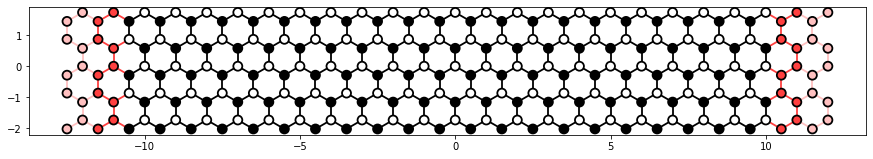

In [5]:
a, b =graphene.sublattices
def family_colors(site):
    return 'w' if site.family == a else 'k' if site.family == b else 'r'


fig, ax = plt.subplots(figsize=(15,10))
kwant.plot(system, site_color=family_colors, site_lw=0.1, ax=ax)
ax.set_aspect('equal')

### Study case 2: With spin degree of freedom but without SOC

In [6]:
sigma_0 = tinyarray.array([[1,0],[0,1]])
sigma_x = tinyarray.array([[0,1],[1,0]])
sigma_y = tinyarray.array([[0,-1j],[1j,0]])
sigma_z = tinyarray.array([[1,0],[0,-1]])

In [7]:
graphene_2 = kwant.lattice.general([(1, 0), (sin_30, cos_30)], # primitive vectors
                                 [(0, 0), (0, 1 / np.sqrt(3))],        # coord. of basis atoms
                                 norbs = 2,                            # number of orbitals per site
                                 name='Graphene'                       # tag of identification
                                )
## Split in sublattices
a, b = graphene_2.sublattices

shape = Rectangle(W=4.5, L=20)
system_spinful = make_graphene_strip(graphene_2, shape, on_site=0*sigma_0, hopping=sigma_0)
leads_spinful = make_graphene_leads(graphene_2, shape.leads, on_site=0*sigma_0, hopping=sigma_0)

for lead in leads_spinful:
    system_spinful.attach_lead(lead)

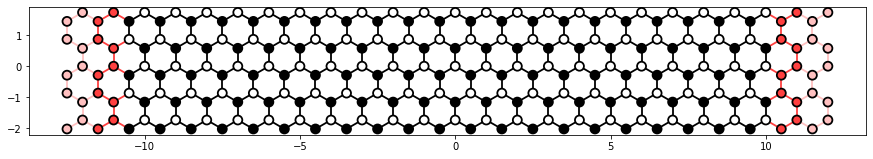

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
kwant.plot(system_spinful, site_color=family_colors, site_lw=0.1, ax=ax)
ax.set_aspect('equal')

It may look the same, but this example is fundamentaly different from the previous one. Notice the hopping and on-site term definitions, instead of scalars now we have matrices. Another important detail appears in the new lattice definition `graphene_2`: now we have passed the argument `norbs=2`, even though the definition of the system would work be fine without such argument, we have to specify the number of orbitals if we want to separate the scattering matrice into spin-up and spin-down.  

### Study case 3: Single adatom without spin

Now let's introduce a single Hydrogen atom on top of the Graphene strip that we've already defined in **Study case 1**. 

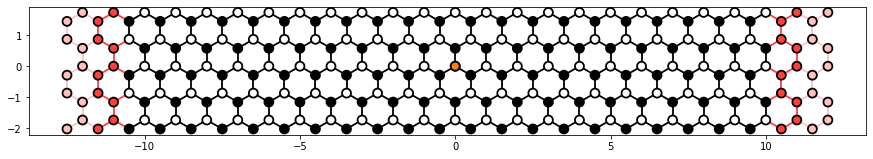

In [9]:
lat_hydrogen = kwant.lattice.square(name='H')

c, = lat_hydrogen.sublattices
a, b =graphene.sublattices
def family_colors(site):
    if site.family == a:
        color = 'w'
    elif site.family == b:
        color = 'k'
    elif site.family == c:
        color = 'C1'
    else:
        color = 'r'
    return color

system[lat_hydrogen(0,0)] = 0
fig, ax = plt.subplots(figsize=(15,10))
kwant.plot(system, site_color=family_colors, site_lw=0.1, ax=ax)
ax.set_aspect('equal')

Notice that we just have defined the on-site energy of the Hydrogen atom and it suffices to make it appear at the figure above. However, we still have to define the hoppings between the **H-site** and its neighbors in the Graphene sheet. The model we have in mind adopt hoppings only between the atoms vertically aligned.   

In [10]:
system[kwant.builder.HoppingKind((0,0), a, c)] = 1

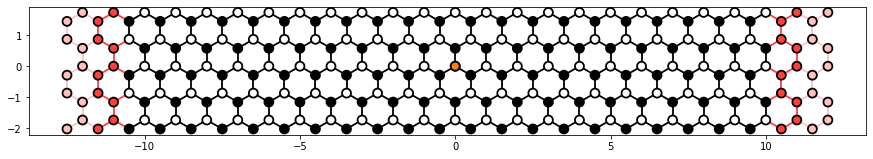

In [11]:
system[lat_hydrogen(0,0)] = 0
fig, ax = plt.subplots(figsize=(15,10))
kwant.plot(system, site_color=family_colors, site_lw=0.1, ax=ax)
ax.set_aspect('equal')

In [12]:
lat_hydrogen(0,0).pos

array([0.0, 0.0])

(-1.0, 1.0)

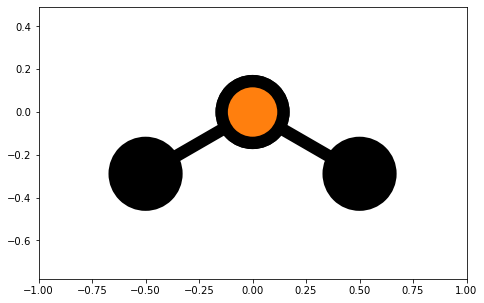

In [13]:
shape_small = Rectangle(W=1, L=1)
system_small = make_graphene_strip(graphene, shape_small)

system_small[lat_hydrogen(0,0)] = 0
system_small[kwant.builder.HoppingKind((0,0), c, a)] = -1

fig, ax = plt.subplots(figsize=(8,5))
kwant.plot(system_small, site_color=family_colors, site_lw=0.1, ax=ax)
ax.set_aspect('equal')# leads = make_graphene_leads(graphene, shape.leads)
ax.set_xlim(-1,1)


# for lead in leads:case
#     system.attach_lead(lead)

In [14]:
def print_info_hop(system):
    for h in system.hopping_value_pairs():
        print('Family \t =', h[0][0].family)
        print('Tag \t = ',h[0][0].tag)
        print('position = ', h[0][0].pos)

        print('Family \t =', h[0][1].family)
        print('Tag \t = ',h[0][1].tag)
        print('position = ', h[0][1].pos)

        print(h[1])
        print()

In [15]:
print_info_hop(system_small)

Family 	 = <Monatomic lattice Graphene0>
Tag 	 =  [0 0]
position =  [0.0 0.0]
Family 	 = <Monatomic lattice Graphene1>
Tag 	 =  [0 -1]
position =  [-0.5 -0.28867513459481275]
1

Family 	 = <Monatomic lattice Graphene0>
Tag 	 =  [0 0]
position =  [0.0 0.0]
Family 	 = <Monatomic lattice Graphene1>
Tag 	 =  [1 -1]
position =  [0.5 -0.28867513459481275]
1

Family 	 = <Monatomic lattice H>
Tag 	 =  [0 0]
position =  [0.0 0.0]
Family 	 = <Monatomic lattice Graphene0>
Tag 	 =  [0 0]
position =  [0.0 0.0]
-1



In [16]:
for s in system_small.sites():
    print(s.family)

<Monatomic lattice Graphene0>
<Monatomic lattice Graphene1>
<Monatomic lattice Graphene1>
<Monatomic lattice H>


In [17]:
s.index

<function Site.index(value, start=0, stop=9223372036854775807, /)>

### Study case 4: Single adatom with spin degree of freedom 

In [18]:
lat_hydrogen_spin = kwant.lattice.square(norbs=2, name='H')
a, b = graphene_2.sublattices
c, = lat_hydrogen_spin.sublattices

In [19]:
zeros_2x2 = tinyarray.array([[0,0],[0,0]])
system_spinful[lat_hydrogen_spin(0,0)] = zeros_2x2

In [20]:
system_spinful[kwant.builder.HoppingKind((0,0), c, a)] = -1 * sigma_0

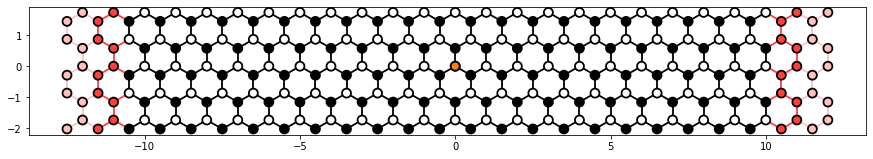

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
kwant.plot(system_spinful, site_color=family_colors, site_lw=0.1, ax=ax)
ax.set_aspect('equal')

(-1.0, 1.0)

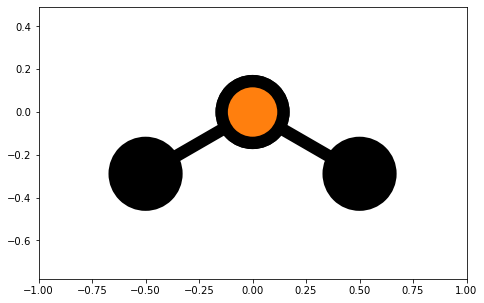

In [22]:
shape_small_spin = Rectangle(W=1, L=1)
system_small_spin = make_graphene_strip(graphene_2, shape_small_spin, hopping=sigma_0, on_site=zeros_2x2)

system_small_spin[lat_hydrogen_spin(0,0)] = zeros_2x2
system_small_spin[kwant.builder.HoppingKind((0,0), c, a)] = -1 * sigma_0

fig, ax = plt.subplots(figsize=(8,5))
kwant.plot(system_small_spin, site_color=family_colors, site_lw=0.1, ax=ax)
ax.set_aspect('equal')# leads = make_graphene_leads(graphene, shape.leads)
ax.set_xlim(-1,1)

In [23]:
print_info_hop(system_small_spin)

Family 	 = <Monatomic lattice Graphene0 with 2 orbitals>
Tag 	 =  [0 0]
position =  [0.0 0.0]
Family 	 = <Monatomic lattice Graphene1 with 2 orbitals>
Tag 	 =  [0 -1]
position =  [-0.5 -0.28867513459481275]
[[1 0]
 [0 1]]

Family 	 = <Monatomic lattice Graphene0 with 2 orbitals>
Tag 	 =  [0 0]
position =  [0.0 0.0]
Family 	 = <Monatomic lattice Graphene1 with 2 orbitals>
Tag 	 =  [1 -1]
position =  [0.5 -0.28867513459481275]
[[1 0]
 [0 1]]

Family 	 = <Monatomic lattice H with 2 orbitals>
Tag 	 =  [0 0]
position =  [0.0 0.0]
Family 	 = <Monatomic lattice Graphene0 with 2 orbitals>
Tag 	 =  [0 0]
position =  [0.0 0.0]
[[-1 0]
 [0 -1]]



## Manual building of the system

### Intrinsic  SOC term

We're going to introduce one SOC term at the time into our system. This term is given in the reference ***PRL 110, 246602 (2013)*** and can be written as

$$
H_{iso} = \frac{i}{3}\sum_{\langle\langle i,j \rangle\rangle}^{\prime} c^{\dagger}_{i\sigma}c_{i\sigma^{\prime}} \left[ \frac{\lambda_I}{\sqrt{3}}\nu_{ij}\hat{s}_z\right]_{\sigma\sigma^{\prime}}
$$

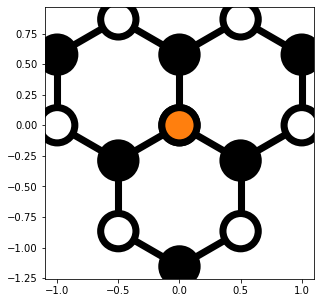

In [24]:
shape_small_spin = Rectangle(W=2.5, L=2.5)
system_small_spin = make_graphene_strip(graphene_2, shape_small_spin, hopping=sigma_0, on_site=zeros_2x2)

system_small_spin[lat_hydrogen_spin(0,0)] = zeros_2x2
system_small_spin[kwant.builder.HoppingKind((0,0), c, a)] = -1 * sigma_0

del system_small_spin[b(2,-2)]
del system_small_spin[b(0,-2)]

fig, ax = plt.subplots(figsize=(8,5))
kwant.plot(system_small_spin, site_color=family_colors, site_lw=0.1, ax=ax)
ax.set_aspect('equal')# leads = make_graphene_leads(graphene, shape.leads)
# ax.set_xlim(-1,1)

In [25]:
λ_I = 1 ## non-realistic; see reference: PRL 110, 246602 (2013)
H_iso = -1j/3 * λ_I/np.sqrt(3) * sigma_z # counter-clockwise

In [26]:
system_small_spin[kwant.builder.HoppingKind((1,0), a, a)] = H_iso
system_small_spin[kwant.builder.HoppingKind((0,1), a, a)] = -H_iso
system_small_spin[kwant.builder.HoppingKind((-1,1), a, a)] = H_iso

system_small_spin[kwant.builder.HoppingKind((1,0), b, b)] = H_iso
system_small_spin[kwant.builder.HoppingKind((0,1), b, b)] = H_iso
system_small_spin[kwant.builder.HoppingKind((-1,1), b, b)] = -H_iso

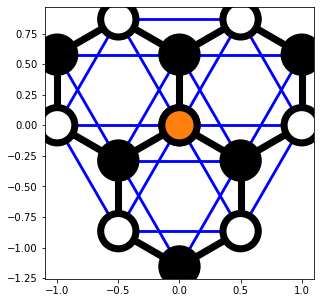

In [27]:
def hopping_colors(site1, site2):
    return 'blue' if site1.family == site2.family else 'black'

def hopping_lw(site1, site2):
    return 0.04 if site1.family == site2.family else 0.1

fig, ax = plt.subplots(figsize=(8,5))
kwant.plot(system_small_spin, 
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')# leads = make_graphene_leads(graphene, shape.leads)
# ax.set_xlim(-1,1)

In [28]:
del system_small_spin[a(0,0), a( 1, 0)]
del system_small_spin[a(0,0), a( 0, 1)]
del system_small_spin[a(0,0), a(-1, 0)]
del system_small_spin[a(0,0), a( 0,-1)]
del system_small_spin[a(0,0), a( 1,-1)]
del system_small_spin[a(0,0), a(-1, 1)]

In [29]:
a(0,0).pos
c(0,0).pos

array([0.0, 0.0])

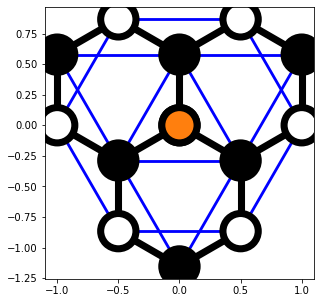

In [30]:
fig, ax = plt.subplots(figsize=(8,5))
kwant.plot(system_small_spin, 
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')# leads = make_graphene_leads(graphene, shape.leads)
# ax.set_xlim(-1,1)

### Adatom induced SOC

$$
H_{asoc} = \frac{i}{3}\sum_{\langle\langle C_H, j \rangle\rangle} A^{\dagger}_{\sigma}c_{j,\sigma^{\prime}} \left[ \frac{\Lambda_I}{\sqrt{3}} \nu_{C_H, j} \hat{s}_z \right]_{\sigma, \sigma^{\prime}}
$$

In [31]:
Λ_I = 2 ## non-realistic; see reference: PRL 110, 246602 (2013)
H_asoc = 1j/3 * Λ_I/np.sqrt(3) * sigma_z # clockwise

In [32]:
## sytem[sublat_1(target), sublat_2(source)]
system_small_spin[a(0,0), a(-1,+1)] = +H_asoc 
system_small_spin[a(0,0), a( 0,+1)] = -H_asoc
system_small_spin[a(0,0), a(+1, 0)] = +H_asoc
system_small_spin[a(0,0), a(+1,-1)] = -H_asoc
system_small_spin[a(0,0), a( 0,-1)] = +H_asoc
system_small_spin[a(0,0), a(-1, 0)] = -H_asoc

In [33]:
def hopping_colors_2(site1, site2):
    if site1.family == site2.family and site1.tag == np.array([0,0]) and site1.family == a:
        color = 'red'
    elif site1.family == site2.family:
        color='blue'
    else:
        color='black'
    return color

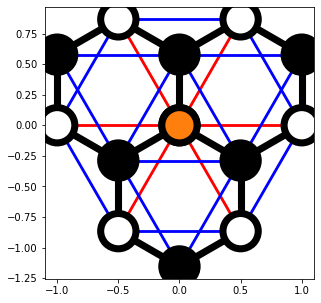

In [34]:
fig, ax = plt.subplots(figsize=(8,5))
kwant.plot(system_small_spin, 
           site_color=family_colors,
           hop_color=hopping_colors_2,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')# leads = make_graphene_leads(graphene, shape.leads)

### Bychkov-Rashba term

$$
H_{BR} = \frac{2i}{3} \sum_{\langle C_H, j \rangle} A^{\dagger}_{\sigma}B_{j\sigma^{\prime}} \left[\Lambda_{BR} (\hat{s} \times \vec{d}_{C_H, j})_z\right]_{\sigma,\sigma^{\prime}}
$$

In [35]:
Λ_BR = 3 ## non-realistic; see reference: PRL 110, 246602 (2013)
H_BR_1 = -(2j/3) * Λ_BR * sigma_x   
H_BR_2 = (2j/3) * Λ_BR * (1/2 * sigma_x + np.sqrt(3)/2 * sigma_y)
H_BR_3 = (2j/3) * Λ_BR * (1/2 * sigma_x - np.sqrt(3)/2 * sigma_y)

In [36]:
system_small_spin[a(0,0), b(0, 0)] += H_BR_1
system_small_spin[a(0,0), b(1,-1)] += H_BR_2
system_small_spin[a(0,0), b(0,-1)] += H_BR_3

In [37]:
system_small_spin[a(0,0),b(0,-1)]

array([[(1+0j), (-1.7320508075688772+1j)],
       [(1.7320508075688772+1j), (1+0j)]])

### Pseudo-spin Inversion Asymmetry: PIA

$$
H_{PIA} = \frac{2i}{3} \sum_{\langle\langle i,j \rangle\rangle} B^{\dagger}_{i\sigma}B_{j\sigma^{\prime}}[\Lambda_{PIA}(\hat{s}\times\vec{D}_{ij})_{z}]_{\sigma\sigma^{\prime}}
$$

In [38]:
Λ_PIA = 4 ## non-realistic; see reference: PRL 110, 246602 (2013)
H_PIA_1 =  2j/3 * Λ_PIA * (np.sqrt(3)/2 * sigma_x + 1/2 * sigma_y) 
H_PIA_2 = -2j/3 * Λ_PIA * (np.sqrt(3)/2 * sigma_x - 1/2 * sigma_y)
H_PIA_3 = -2j/3 * Λ_PIA * sigma_y

In [39]:
system_small_spin[b(0,0), b(1,-1)]  += H_PIA_1
system_small_spin[b(0,-1), b(0,0)]  += H_PIA_2
system_small_spin[b(1,-1), b(0,-1)] += H_PIA_3

## Programatic system building tests:

### Questions to answer:

* How to keep track the positions of the Hydrogen atoms?
* Using the position of the Hydrogen atoms, how to get the $C_H$-atom?
* How to get the $C_H$'s nearest-neighbors (NN)?
* How to get the $C_H$'s **next**-nearest-neighbors (NNN)?
* How to get the unit vectors linking the $C_H$ and its NN?
* How to get the unit vectors linking the $C_H$ and its NNN?

In [40]:
# type(system_small_spin[a(0,0)])
# dir(system_small_spin[a(0,0)])
system_small_spin[a(0,0)]

array([[0, 0],
       [0, 0]])

In [42]:
dir(a)

['__abstractmethods__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_prim_vecs',
 'cached_str',
 'canonical_repr',
 'closest',
 'dim',
 'hash',
 'inv_pv',
 'lattice_dim',
 'n_closest',
 'name',
 'neighbors',
 'norbs',
 'normalize_tag',
 'offset',
 'pos',
 'prim_vecs',
 'reduced_vecs',
 'shape',
 'sublattices',
 'transf',
 'vec',
 'voronoi',
 'wire']

In [60]:
a.name

'Graphene0'

In [61]:
b.name

'Graphene1'

In [72]:
np.sum(b(0,0).pos**2.)

TypeError: unsupported operand type(s) for ** or pow(): 'tinyarray.ndarray_float' and 'float'

In [77]:
dir(b(0,0).pos)

['__abs__',
 '__add__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pos__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 'conjugate',
 'dtype',
 'ndim',
 'shape',
 'size',
 'transpose']

In [82]:
b(0,0).pos

array([0.0, 0.5773502691896258])

In [83]:
0.577**2

0.332929

In [91]:
np.sum(b(0,0).pos)

0.5773502691896258

In [43]:
vizinhos_de_a = a.neighbors()

In [44]:
type(vizinhos_de_a[0])

kwant.builder.HoppingKind

In [45]:
dir(vizinhos_de_a[0])

['__add__',
 '__call__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 'count',
 'delta',
 'family_a',
 'family_b',
 'index']

In [46]:
help(a)

Help on Monatomic in module kwant.lattice object:

class Monatomic(kwant.builder.SiteFamily, Polyatomic)
 |  Monatomic(prim_vecs, offset=None, name='', norbs=None)
 |  
 |  A Bravais lattice with a single site in the basis.
 |  
 |  Instances of this class provide the `~kwant.builder.SiteFamily` interface.
 |  Site tags (see `~kwant.builder.SiteFamily`) are sequences of integers and
 |  describe the lattice coordinates of a site.
 |  
 |  ``Monatomic`` instances are used as site families on their own or as
 |  sublattices of `Polyatomic` lattices.
 |  
 |  Parameters
 |  ----------
 |  prim_vecs : 2d array-like of floats
 |      Primitive vectors of the Bravais lattice.
 |  
 |  offset : vector of floats
 |      Displacement of the lattice origin from the real space
 |      coordinates origin.
 |  
 |  Attributes
 |  ----------
 |  ``offset`` : vector
 |      Displacement of the lattice origin from the real space coordinates origin
 |  
 |  Method resolution order:
 |      Monatomic
 |

In [47]:
help(vizinhos_de_a[0])

Help on HoppingKind in module kwant.builder object:

class HoppingKind(builtins.tuple)
 |  HoppingKind(delta, family_a, family_b=None)
 |  
 |  A pattern for matching hoppings.
 |  
 |  An alias exists for this common name: ``kwant.HoppingKind``.
 |  
 |  A hopping ``(a, b)`` matches precisely when the site family of ``a`` equals
 |  `family_a` and that of ``b`` equals `family_b` and ``(a.tag - b.tag)`` is
 |  equal to `delta`.  In other words, the matching hoppings have the form:
 |  ``(family_a(x + delta), family_b(x))``
 |  
 |  Parameters
 |  ----------
 |  delta : Sequence of integers
 |      The sequence is interpreted as a vector with integer elements.
 |  family_a : `~kwant.builder.SiteFamily`
 |  family_b : `~kwant.builder.SiteFamily` or ``None`` (default)
 |      The default value means: use the same family as `family_a`.
 |  
 |  Notes
 |  -----
 |  A ``HoppingKind`` is a callable object: When called with a
 |  `~kwant.builder.Builder` as sole argument, an instance of this c

In [48]:
type(system_small_spin[a(0,0), a(1,0)])

tinyarray.ndarray_complex

In [49]:
system_small_spin[a(0,0), a(1,0)]

array([[0.3849001794597505j, 0j],
       [0j, (-0-0.3849001794597505j)]])

In [50]:
sites_family = [h.family for h in system_small_spin.sites()]
sites_tag = [h.tag for h in system_small_spin.sites()]

In [51]:
print(a)

<Monatomic lattice Graphene0 with 2 orbitals>


In [52]:
print(b)

<Monatomic lattice Graphene1 with 2 orbitals>


In [53]:
print(c)

<Monatomic lattice H with 2 orbitals>


In [54]:
sites_tag

[array([0, 0]),
 array([0, 0]),
 array([1, -1]),
 array([0, -1]),
 array([0, -1]),
 array([1, 0]),
 array([0, 1]),
 array([-1, 1]),
 array([1, -1]),
 array([-1, 0]),
 array([-1, 0]),
 array([1, 0]),
 array([1, -2]),
 array([0, 0])]

In [55]:
dir(sites_family[0])

['__abstractmethods__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_prim_vecs',
 'cached_str',
 'canonical_repr',
 'closest',
 'dim',
 'hash',
 'inv_pv',
 'lattice_dim',
 'n_closest',
 'name',
 'neighbors',
 'norbs',
 'normalize_tag',
 'offset',
 'pos',
 'prim_vecs',
 'reduced_vecs',
 'shape',
 'sublattices',
 'transf',
 'vec',
 'voronoi',
 'wire']

In [56]:
sites_names = [family.name for family in sites_family] 

In [57]:
sites_names

['Graphene0',
 'Graphene1',
 'Graphene0',
 'Graphene0',
 'Graphene1',
 'Graphene1',
 'Graphene0',
 'Graphene0',
 'Graphene1',
 'Graphene0',
 'Graphene1',
 'Graphene0',
 'Graphene1',
 'H']

In [93]:
H_sites = [site for site in system_small_spin.sites() if site.family.name=='H']

In [94]:
[site.tag for site in H_sites]

[array([0, 0])]

In [ ]:
[site.tag for site in H_sites]